In [1]:

import sys
import os
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('../scripts'))

In [5]:
from telecom_analysis import load_data_using_sqlalchemy


In [6]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [7]:
df

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,2.780823e+08,1.434415e+07,1.717444e+08,8.814393e+06,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,6.087501e+08,1.170709e+06,5.269042e+08,1.505514e+07,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,2.295846e+08,3.956300e+05,4.106926e+08,4.215763e+06,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,7.995382e+08,1.084972e+07,7.490399e+08,1.279728e+07,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,5.277072e+08,3.529801e+06,5.507095e+08,1.391032e+07,38542814.0,569138589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0


In [8]:
# Define SQL query to get the top 10 handsets
query_handsets = """
SELECT "Handset Type" AS handset, COUNT(*) AS usage_count
FROM public.xdr_data
GROUP BY "Handset Type"
ORDER BY usage_count DESC
LIMIT 10;
"""

# Load data from PostgreSQL
df_handsets = load_data_using_sqlalchemy(query_handsets)

# Inspect the data
if df_handsets is not None:
    print("Top 10 handsets:")
    print(df_handsets.head(10))
else:
    print("Failed to load data.")

Top 10 handsets:
                        handset  usage_count
0              Huawei B528S-23A        19752
1       Apple iPhone 6S (A1688)         9419
2        Apple iPhone 6 (A1586)         9023
3                     undefined         8987
4        Apple iPhone 7 (A1778)         6326
5       Apple iPhone Se (A1723)         5187
6        Apple iPhone 8 (A1905)         4993
7       Apple iPhone Xr (A2105)         4568
8  Samsung Galaxy S8 (Sm-G950F)         4520
9        Apple iPhone X (A1901)         3813


In [9]:
# Define SQL query to identify top 3 manufacturers
query_manufacturers = """
SELECT "Handset Manufacturer" AS manufacturer, COUNT(*) AS usage_count
FROM public.xdr_data
GROUP BY "Handset Manufacturer"
ORDER BY usage_count DESC
LIMIT 3;
"""

df_manufacturers = load_data_using_sqlalchemy(query_manufacturers)

if df_manufacturers is not None:
    print("Top 3 manufacturers:")
    print(df_manufacturers.head())
else:
    print("Failed to load data.")

Top 3 manufacturers:
  manufacturer  usage_count
0        Apple        59565
1      Samsung        40839
2       Huawei        34423


In [10]:

# Identify top 5 handsets per top 3 handset manufacturer
if df_manufacturers is not None:
    manufacturers = df_manufacturers['manufacturer'].tolist()
    for manufacturer in manufacturers:
        query_top_handsets = f"""
        SELECT "Handset Type" AS handset, COUNT(*) AS usage_count
        FROM public.xdr_data
        WHERE "Handset Manufacturer" = '{manufacturer}'
        GROUP BY "Handset Type"
        ORDER BY usage_count DESC
        LIMIT 5;
        """
        df_top_handsets = load_data_using_sqlalchemy(query_top_handsets)
        
        if df_top_handsets is not None:
            print(f"Top 5 handsets for {manufacturer}:")
            print(df_top_handsets.head())
        else:
            print(f"Failed to load data for manufacturer {manufacturer}.")


Top 5 handsets for Apple:
                   handset  usage_count
0  Apple iPhone 6S (A1688)         9419
1   Apple iPhone 6 (A1586)         9023
2   Apple iPhone 7 (A1778)         6326
3  Apple iPhone Se (A1723)         5187
4   Apple iPhone 8 (A1905)         4993
Top 5 handsets for Samsung:
                        handset  usage_count
0  Samsung Galaxy S8 (Sm-G950F)         4520
1    Samsung Galaxy A5 Sm-A520F         3724
2   Samsung Galaxy J5 (Sm-J530)         3696
3   Samsung Galaxy J3 (Sm-J330)         3484
4  Samsung Galaxy S7 (Sm-G930X)         3199
Top 5 handsets for Huawei:
                          handset  usage_count
0                Huawei B528S-23A        19752
1                    Huawei E5180         2079
2  Huawei P20 Lite Huawei Nova 3E         2021
3                      Huawei P20         1480
4                  Huawei Y6 2018          997


In [11]:
# Define SQL query to aggregate user behavior
query_user_behavior = """
SELECT
    "MSISDN/Number" AS user,
    COUNT(*) AS session_count,
    SUM("Dur. (ms)") AS total_session_duration, -- Assuming "Dur. (ms)" is session duration
    SUM("Total DL (Bytes)") AS total_download,
    SUM("Total UL (Bytes)") AS total_upload,
    SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)") AS total_data_volume,
    SUM("Social Media DL (Bytes)") AS social_media_dl,
    SUM("Social Media UL (Bytes)") AS social_media_ul,
    SUM("Google DL (Bytes)") AS google_dl,
    SUM("Google UL (Bytes)") AS google_ul,
    SUM("Email DL (Bytes)") AS email_dl,
    SUM("Email UL (Bytes)") AS email_ul,
    SUM("Youtube DL (Bytes)") AS youtube_dl,
    SUM("Youtube UL (Bytes)") AS youtube_ul,
    SUM("Netflix DL (Bytes)") AS netflix_dl,
    SUM("Netflix UL (Bytes)") AS netflix_ul,
    SUM("Gaming DL (Bytes)") AS gaming_dl,
    SUM("Gaming UL (Bytes)") AS gaming_ul,
    SUM("Other DL (Bytes)") AS other_dl,
    SUM("Other UL (Bytes)") AS other_ul
FROM public.xdr_data
GROUP BY "MSISDN/Number";
"""

# Load user behavior data
df_user_behavior = load_data_using_sqlalchemy(query_user_behavior)

# Inspect the data
if df_user_behavior is not None:
    print("User behavior analysis:")
    print(df_user_behavior.head())
else:
    print("Failed to load data.")


User behavior analysis:
           user  session_count  total_session_duration  total_download  \
0  3.360100e+10              1                116720.0    8.426375e+08   
1  3.360100e+10              1                181230.0    1.207552e+08   
2  3.360100e+10              1                134969.0    5.566597e+08   
3  3.360101e+10              1                 49878.0    4.019932e+08   
4  3.360101e+10              2                 37104.0    1.363130e+09   

   total_upload  total_data_volume  social_media_dl  social_media_ul  \
0    36053108.0       8.786906e+08        2206504.0          25631.0   
1    36104459.0       1.568596e+08        2598548.0          62017.0   
2    39306820.0       5.959665e+08        3148004.0          47619.0   
3    20327526.0       4.223207e+08         251469.0          28825.0   
4    94280527.0       1.457411e+09        2861230.0          51312.0   

    google_dl  google_ul   email_dl   email_ul  youtube_dl  youtube_ul  \
0   3337123.0  1051882.0

In [12]:
print(df_user_behavior.info())
print(df_user_behavior.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106857 entries, 0 to 106856
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user                    106857 non-null  float64
 1   session_count           106857 non-null  int64  
 2   total_session_duration  106857 non-null  float64
 3   total_download          106857 non-null  float64
 4   total_upload            106857 non-null  float64
 5   total_data_volume       106857 non-null  float64
 6   social_media_dl         106857 non-null  float64
 7   social_media_ul         106857 non-null  float64
 8   google_dl               106857 non-null  float64
 9   google_ul               106857 non-null  float64
 10  email_dl                106857 non-null  float64
 11  email_ul                106857 non-null  float64
 12  youtube_dl              106857 non-null  float64
 13  youtube_ul              106857 non-null  float64
 14  netflix_dl          

In [26]:
print(df_user_behavior.isnull().sum())

# Replace missing values with mean for numeric columns
df_user_behavior.fillna(df_user_behavior.mean(), inplace=True)


user                      0
session_count             0
total_session_duration    0
total_download            0
total_upload              0
total_data_volume         0
social_media_dl           0
social_media_ul           0
google_dl                 0
google_ul                 0
email_dl                  0
email_ul                  0
youtube_dl                0
youtube_ul                0
netflix_dl                0
netflix_ul                0
gaming_dl                 0
gaming_ul                 0
other_dl                  0
other_ul                  0
decile                    0
dtype: int64


In [27]:
import numpy as np
from scipy import stats

# Detect and handle outliers using Z-scores
z_scores = stats.zscore(df_user_behavior.select_dtypes(include=['float64', 'int64']))
abs_z_scores = np.abs(z_scores)
df_user_behavior = df_user_behavior[(abs_z_scores < 3).all(axis=1)]

In [28]:
import pandas as pd
 #Segment users into deciles based on total_session_duration
df_user_behavior['decile'] = pd.qcut(df_user_behavior['total_session_duration'], 10, labels=False) + 1

# Compute total data (DL+UL) per decile class
decile_data = df_user_behavior.groupby('decile')[['total_download', 'total_upload']].sum()
print(decile_data)

        total_download  total_upload
decile                              
1         4.624551e+12  4.163939e+11
2         5.115790e+12  4.628227e+11
3         5.654416e+12  5.123913e+11
4         5.736226e+12  5.181631e+11
5         3.743860e+12  3.382006e+11
6         5.377226e+12  4.867299e+11
7         5.156517e+12  4.638705e+11
8         6.257398e+12  5.676865e+11
9         6.319682e+12  5.693677e+11
10        7.689687e+12  6.970240e+11


In [29]:
metrics = df_user_behavior[['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']].agg(['mean', 'median', 'std', 'min', 'max'])
print(metrics)

        total_session_duration  total_download  total_upload  \
mean             119458.509144    5.597257e+08  5.059516e+07   
median            96103.000000    5.394757e+08  4.535644e+07   
std               81421.837085    3.352988e+08  2.194246e+07   
min                7142.000000    8.827082e+06  2.866892e+06   
max              485520.000000    1.936033e+09  1.550461e+08   

        total_data_volume  
mean         6.103208e+08  
median       5.860448e+08  
std          3.465140e+08  
min          3.324901e+07  
max          2.066833e+09  


In [30]:
# Dispersion parameters
# Non-Graphical Univariate Analysis
dispersion = df_user_behavior[['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']].agg(['var', 'std'])
print(dispersion)

     total_session_duration  total_download  total_upload  total_data_volume
var            6.629516e+09    1.124253e+17  4.814714e+14       1.200720e+17
std            8.142184e+04    3.352988e+08  2.194246e+07       3.465140e+08


In [38]:
# Fill missing values with 0 before aggregation
df_user_behavior[quantitative_columns] = df_user_behavior[quantitative_columns].apply(pd.to_numeric, errors='coerce')



# Perform the aggregation
dispersion_metrics = df_user_behavior[quantitative_columns].agg(['mean', 'median', 'std', 'var', 'min', 'max'])
dispersion_metrics['range'] = df_user_behavior[quantitative_columns].apply(lambda x: x.max() - x.min())
dispersion_metrics['iqr'] = df_user_behavior[quantitative_columns].apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

print(dispersion_metrics)


                user  session_count  total_session_duration  total_download  \
mean    3.367394e+10       1.231741            1.194585e+05    5.597257e+08   
median  3.366361e+10       1.000000            9.610300e+04    5.394757e+08   
std     4.536039e+07       0.445655            8.142184e+04    3.352988e+08   
var     2.057565e+15       0.198608            6.629516e+09    1.124253e+17   
min     3.360100e+10       1.000000            7.142000e+03    8.827082e+06   
max     3.379000e+10       3.000000            4.855200e+05    1.936033e+09   

        total_upload  total_data_volume  social_media_dl  social_media_ul  \
mean    5.059516e+07       6.103208e+08     2.209586e+06     4.053237e+04   
median  4.535644e+07       5.860448e+08     2.133318e+06     3.918900e+04   
std     2.194246e+07       3.465140e+08     1.391362e+06     2.563627e+04   
var     4.814714e+14       1.200720e+17     1.935888e+12     6.572186e+08   
min     2.866892e+06       3.324901e+07     1.200000e+01     

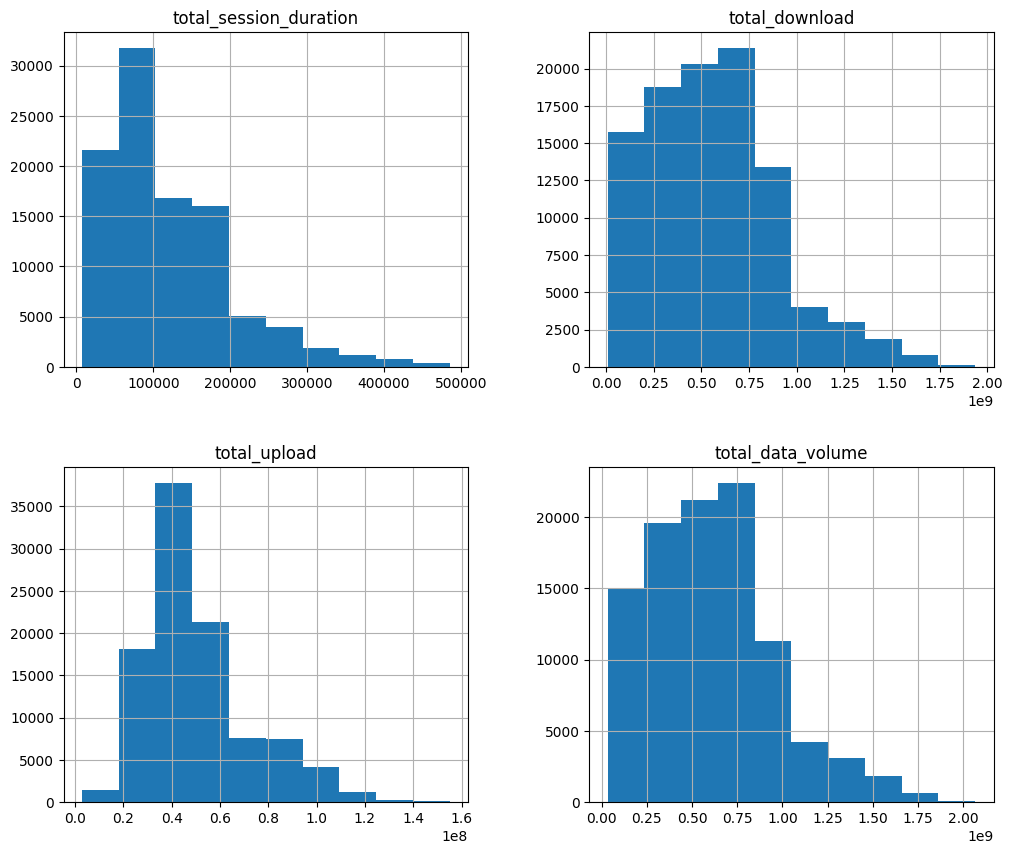

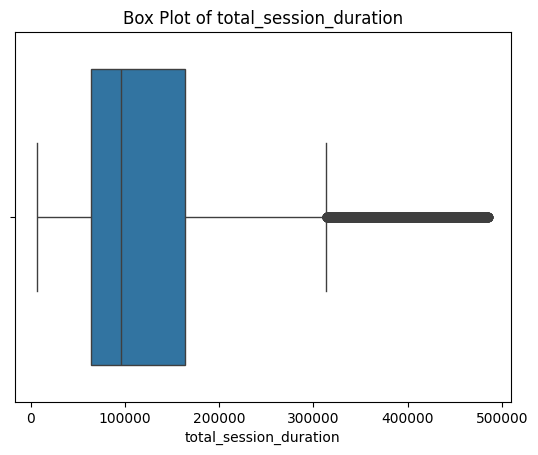

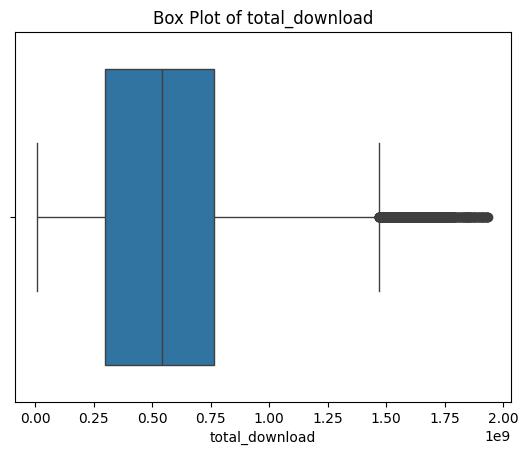

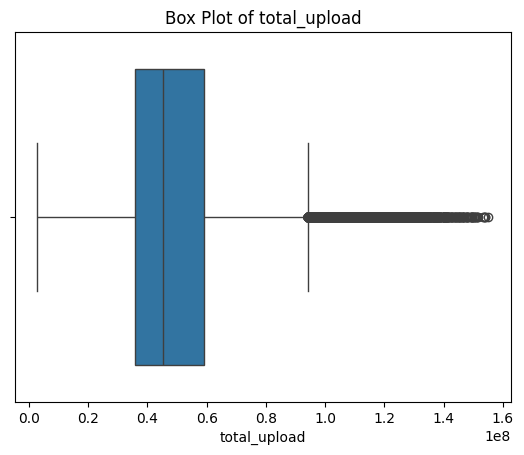

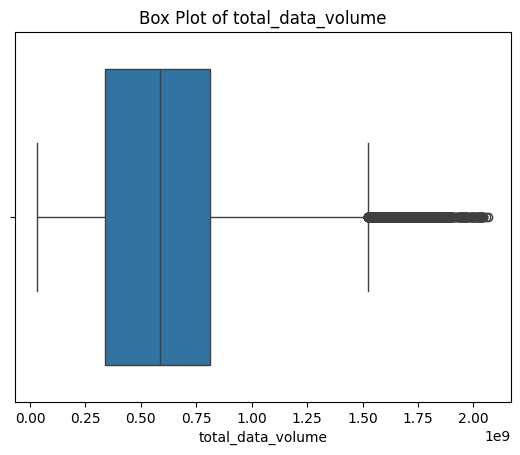

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
df_user_behavior[['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']].hist(figsize=(12, 10))
plt.show()

# Box plots
for column in ['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']:
    sns.boxplot(x=df_user_behavior[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

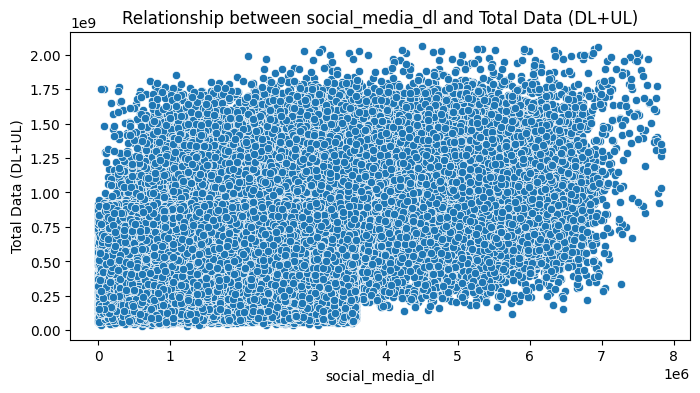

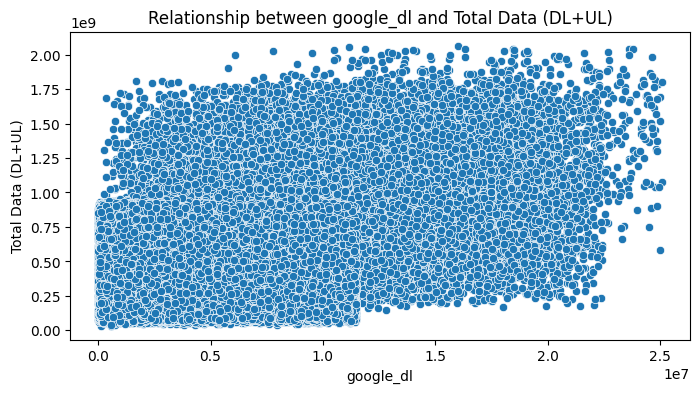

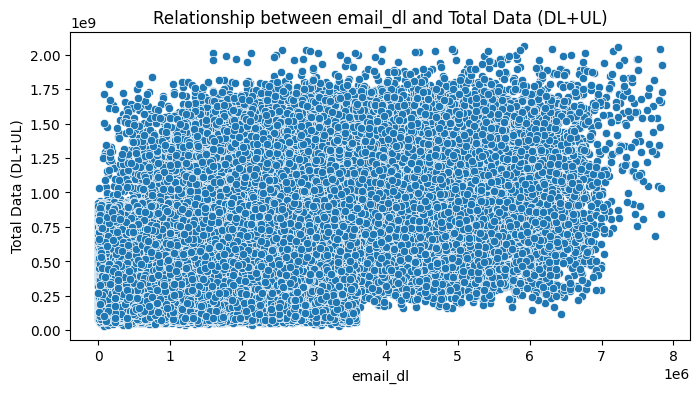

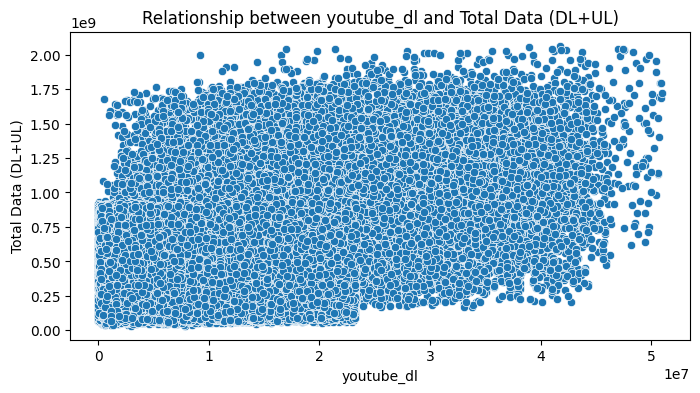

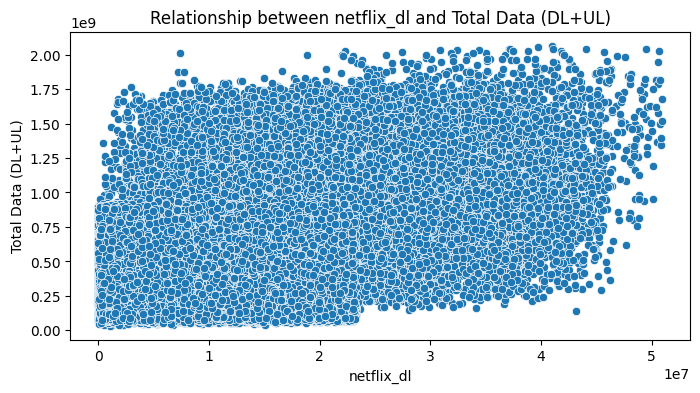

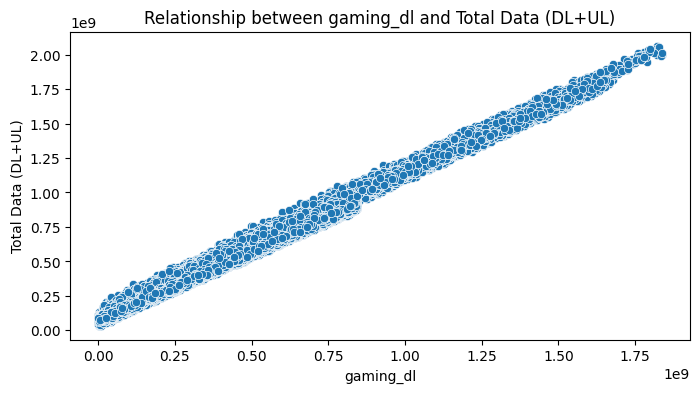

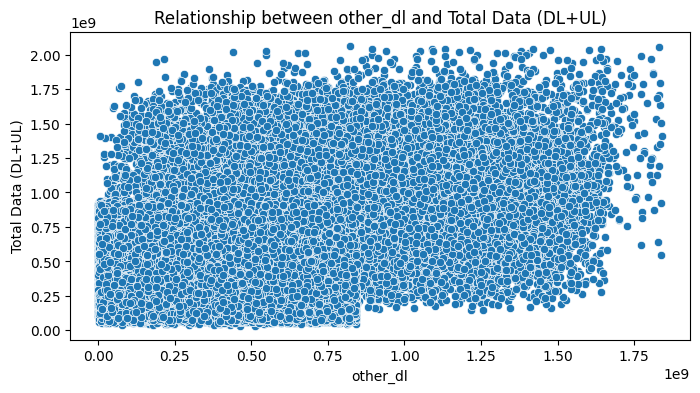

In [34]:
# Calculate total data (DL+UL) for each user
df_user_behavior['total_data'] = df_user_behavior['total_download'] + df_user_behavior['total_upload']

# Plot scatter plots to explore relationships between applications and total data
application_columns = ['social_media_dl', 'google_dl', 'email_dl', 'youtube_dl', 'netflix_dl', 'gaming_dl', 'other_dl']

for app in application_columns:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=df_user_behavior[app], y=df_user_behavior['total_data'])
    plt.title(f'Relationship between {app} and Total Data (DL+UL)')
    plt.xlabel(f'{app}')
    plt.ylabel('Total Data (DL+UL)')
    plt.show()

Correlation Matrix:
                 social_media_dl  google_dl  email_dl  youtube_dl  netflix_dl  \
social_media_dl         1.000000   0.321553  0.324558    0.318370    0.320726   
google_dl               0.321553   1.000000  0.320178    0.321448    0.321626   
email_dl                0.324558   0.320178  1.000000    0.319726    0.317552   
youtube_dl              0.318370   0.321448  0.319726    1.000000    0.320384   
netflix_dl              0.320726   0.321626  0.317552    0.320384    1.000000   
gaming_dl               0.321453   0.320196  0.314789    0.316787    0.317417   
other_dl                0.321553   0.318637  0.316262    0.318900    0.314087   

                 gaming_dl  other_dl  
social_media_dl   0.321453  0.321553  
google_dl         0.320196  0.318637  
email_dl          0.314789  0.316262  
youtube_dl        0.316787  0.318900  
netflix_dl        0.317417  0.314087  
gaming_dl         1.000000  0.314609  
other_dl          0.314609  1.000000  


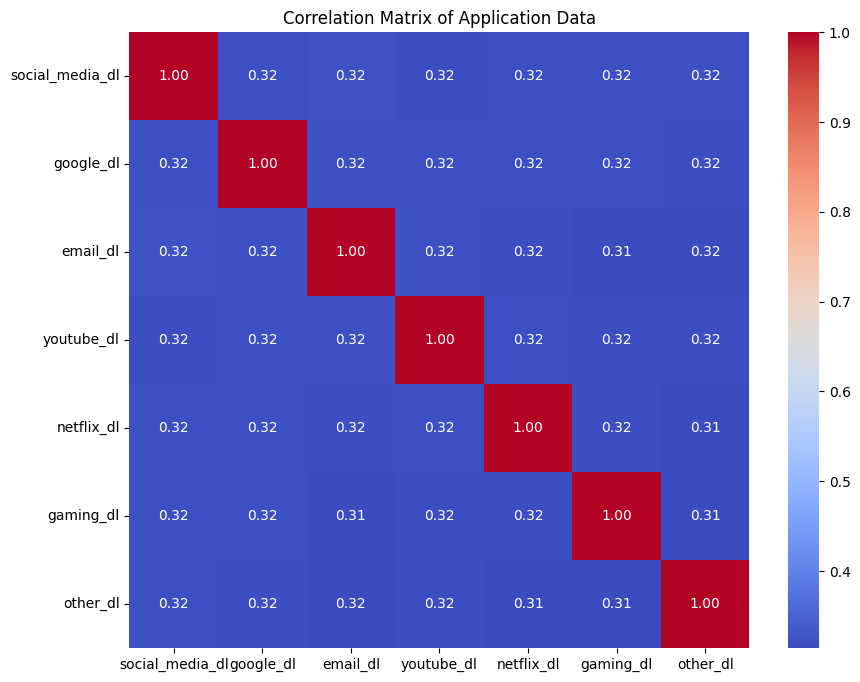

In [43]:
# Select relevant columns for correlation analysis
correlation_columns = ['social_media_dl', 'google_dl', 'email_dl', 'youtube_dl', 'netflix_dl', 'gaming_dl', 'other_dl']

# Compute correlation matrix
correlation_matrix = df_user_behavior[correlation_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Application Data')
plt.show()


Correlation Matrix:
                 social_media_dl  google_dl  email_dl  youtube_dl  netflix_dl  \
social_media_dl         1.000000   0.321553  0.324558    0.318370    0.320726   
google_dl               0.321553   1.000000  0.320178    0.321448    0.321626   
email_dl                0.324558   0.320178  1.000000    0.319726    0.317552   
youtube_dl              0.318370   0.321448  0.319726    1.000000    0.320384   
netflix_dl              0.320726   0.321626  0.317552    0.320384    1.000000   
gaming_dl               0.321453   0.320196  0.314789    0.316787    0.317417   
other_dl                0.321553   0.318637  0.316262    0.318900    0.314087   

                 gaming_dl  other_dl  
social_media_dl   0.321453  0.321553  
google_dl         0.320196  0.318637  
email_dl          0.314789  0.316262  
youtube_dl        0.316787  0.318900  
netflix_dl        0.317417  0.314087  
gaming_dl         1.000000  0.314609  
other_dl          0.314609  1.000000  


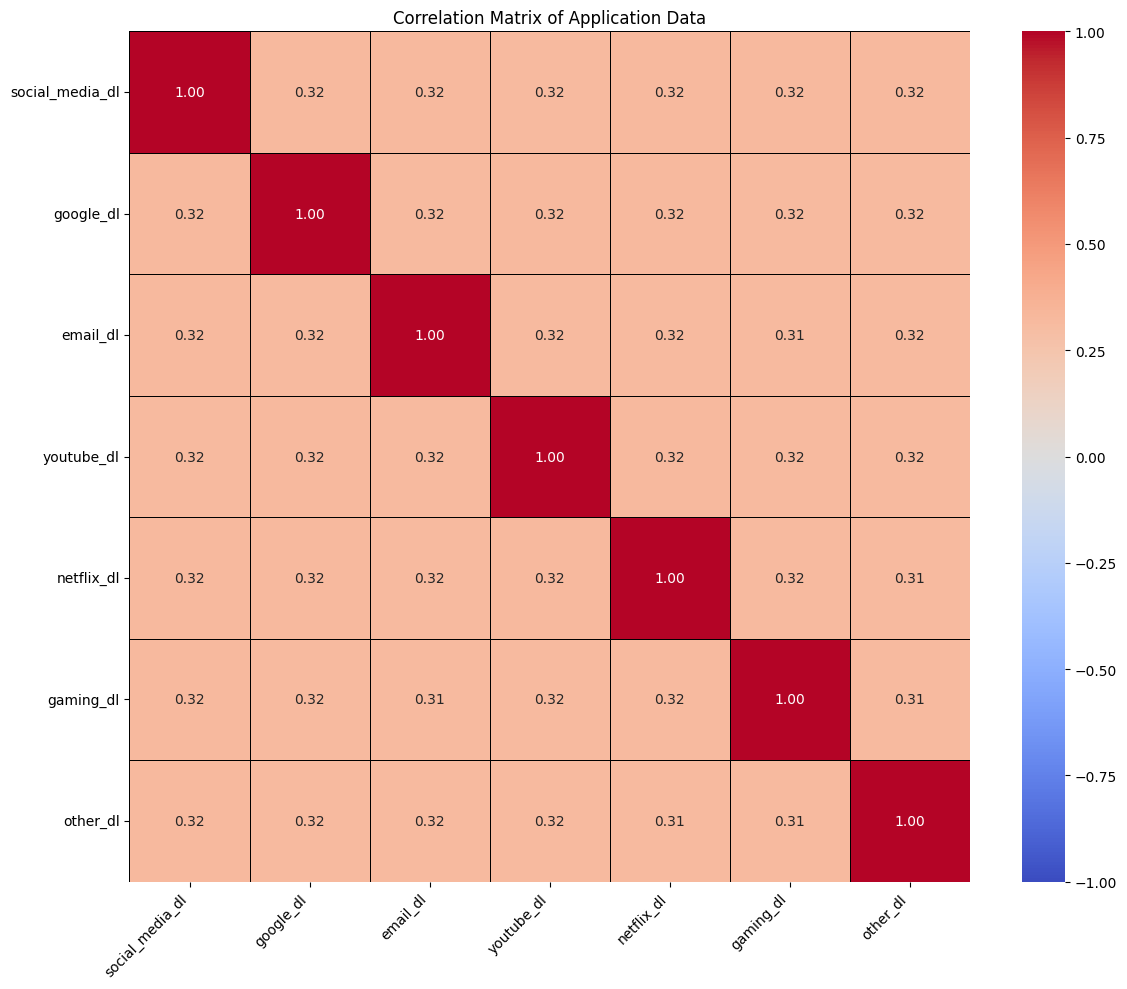

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_user_behavior is already defined and contains your data

# Select relevant columns for correlation analysis
correlation_columns = ['social_media_dl', 'google_dl', 'email_dl', 'youtube_dl', 'netflix_dl', 'gaming_dl', 'other_dl']

# Compute correlation matrix
correlation_matrix = df_user_behavior[correlation_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='black')

# Improve the readability of the plot
plt.title('Correlation Matrix of Application Data')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust the layout to ensure everything fits

plt.show()


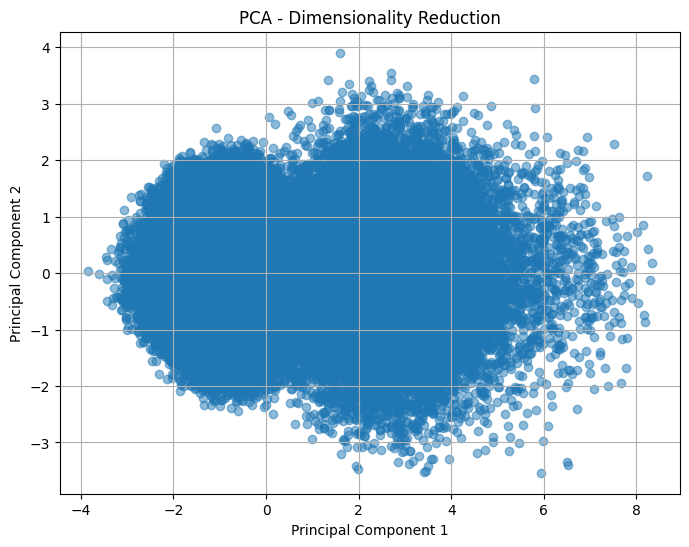

Explained variance by the 2 components: [0.41636397 0.09819152]
Total variance explained by the 2 components: 0.51
Principal Component 1 explains 41.64% of the variance
Principal Component 2 explains 9.82% of the variance
Cumulative explained variance by the 2 components: 51.46%


In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df_user_behavior and correlation_columns are predefined
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_user_behavior[correlation_columns])

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(scaled_data)

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA - Dimensionality Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)  # Add grid to the plot for better visualization
plt.show()

# Explained variance ratio (how much information each component contains)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by the 2 components: {explained_variance}')

total_explained_variance = explained_variance.sum()
print(f'Total variance explained by the 2 components: {total_explained_variance:.2f}')

# Print the proportion of variance explained by each component
for i, var in enumerate(explained_variance, start=1):
    print(f'Principal Component {i} explains {var:.2%} of the variance')

# Print the cumulative explained variance
cumulative_variance = total_explained_variance
print(f'Cumulative explained variance by the 2 components: {cumulative_variance:.2%}')
